# Exploring the Adder model

The goal of this section is to introduce

- an intuition for an optimally tuned model / neural network for addition
- hyperparameter search

In [ ]:
!pip install torchviz matplotlib graphviz

# A simpler Adder

In the [000-Introduction](000-Introduction.pynb), the Adder was introduced with several layers each having 4 nodes.

The next model will have no hidden layers and 

Adder(
  (output): Linear(in_features=2, out_features=1, bias=True)
)


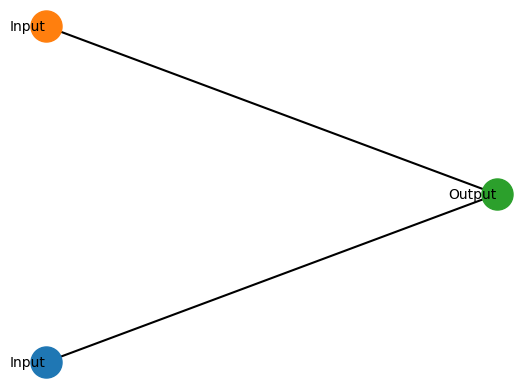

tensor([57.1360], grad_fn=<ViewBackward0>)

In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import shared

# Define the neural network model
class Adder(torch.nn.Module):
    def __init__(self):
        super(Adder, self).__init__()
        self.output = torch.nn.Linear(2, 1)
    
    def forward(self, x):
        return self.output(x)


# Calling this to make the work repeatable
shared.set_random_seed(42)
model = Adder()
print(model)
shared.draw_dnn([2, 1])

# This won't print a good result since the model is not trained
model(torch.Tensor([30, 70]))

In [37]:
# Train the model in the same way that it was in 000-Introduction

shared.set_random_seed(42)
model = Adder()

# Hyperparameters
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

epochs = 2000

# Generate 10,000 random pairs between -500 and 500
input_data = (torch.rand(10000, 2) * 1000) - 500

# Calculate the target sum for each pair
target = torch.sum(input_data, dim=1, keepdim=True)

for i in range(epochs):
    # Get a prediction from the model
    prediction = model(input_data)

    # Compute loss by comparing the prediction to target
    loss = criterion(prediction, target)

    # Print the first epoch, and one for every 10% thereafter.
    print(f"[{i+1}] Loss: {loss.item()}") if i == 0 or i % (epochs / 10) == (epochs / 10)-1 else None
        
    # Zero the gradients so that they can accumulate during loss.backward()
    optimizer.zero_grad()
    # Set all of the gradients in the network based upon the loss
    loss.backward()
    # Alter the weights in the network based upon the accumulated gradients and the learning rate using the optimizer
    optimizer.step()

def test_model(model, a, b):
    return model(torch.Tensor([[a, b]])).item()

print(f"30 + 70 = {test_model(model, 30, 70):0.2f}")
print(f"70 + 30 = {test_model(model, 70, 30):0.2f}")
print(f"130 + -30 = {test_model(model, 130, -30):0.2f}")
print(f"3 + 7 = {test_model(model, 3, 7):0.2f}")
print(f"33 + 7 = {test_model(model, 33, 7):0.2f}")
print(f"-330000 + 30000 = {test_model(model, -330000, 30000):0.2f}")

[1] Loss: 32311.173828125
[200] Loss: 26800.296875
[400] Loss: 21999.75
[600] Loss: 17869.798828125
[800] Loss: 14344.5693359375
[1000] Loss: 11362.8251953125
[1200] Loss: 8867.384765625
[1400] Loss: 6804.47607421875
[1600] Loss: 5123.32421875
[1800] Loss: 3775.833984375
[2000] Loss: 2716.3427734375
30 + 70 = 87.75
70 + 30 = 86.33
130 + -30 = 84.21
3 + 7 = 8.39
33 + 7 = 34.10
-330000 + 30000 = -256027.22


# Model inaccuracy can simply mean that more training loops are necessary

A training loop is where the model predicts all of the data, calculates the loss against the target, then applies the loss back to the network using gradient descent and a learning rate usually using some type of optimizer such as Adam.

This training loop is called an epoch.  In the example above, 2000 epochs was not enough, but it is clear that with every couple hundred epochs, the answer was closer to being right. 

To make this easier to test, I'm going to encapsulate everything except the hyperparameters into a couple functions.

In [38]:
def train_model(model, epochs, optimizer, criterion):
    # Generate 10,000 random pairs between -500 and 500
    input_data = (torch.rand(10000, 2) * 1000) - 500
    
    # Calculate the target sum for each pair
    target = torch.sum(input_data, dim=1, keepdim=True)

    for i in range(epochs):
        # Get a prediction from the model
        prediction = model(input_data)
    
        # Compute loss by comparing the prediction to target
        loss = criterion(prediction, target)
    
        # Print the first epoch, and one for every 10% thereafter.
        print(f"[{i+1}] Loss: {loss.item()}") if i == 0 or i % (epochs / 10) == (epochs / 10)-1 else None
            
        # Zero the gradients so that they can accumulate during loss.backward()
        optimizer.zero_grad()
        # Set all of the gradients in the network based upon the loss
        loss.backward()
        # Alter the weights in the network based upon the accumulated gradients and the learning rate using the optimizer
        optimizer.step()

    return loss.item()

def test_model(model, a, b):
    return model(torch.Tensor([[a, b]])).item()

def run_tests(model):
    print(f"30 + 70 = {test_model(model, 30, 70):0.2f}")
    print(f"70 + 30 = {test_model(model, 70, 30):0.2f}")
    print(f"130 + -30 = {test_model(model, 130, -30):0.2f}")
    print(f"3 + 7 = {test_model(model, 3, 7):0.2f}")
    print(f"33 + 7 = {test_model(model, 33, 7):0.2f}")
    print(f"-330000 + 30000 = {test_model(model, -330000, 30000):0.2f}")

# Trying 10000 epochs

Sometimes all a model needs is more epochs

In [39]:
shared.set_random_seed(42)
model = Adder()

# Hyperparameters
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 10000

loss = train_model(model, epochs, optimizer, criterion)
run_tests(model)
print(f"Final Loss: {loss}")

[1] Loss: 32311.173828125
[1000] Loss: 11362.8251953125
[2000] Loss: 2716.3427734375
[3000] Loss: 322.765380859375
[4000] Loss: 11.216792106628418
[5000] Loss: 0.06645700335502625
[6000] Loss: 0.0022333788219839334
[7000] Loss: 8.012600301299244e-05
[8000] Loss: 8.322875260091678e-07
[9000] Loss: 1.9726560651633918e-07
[10000] Loss: 6.793563755991272e-08
30 + 70 = 100.00
70 + 30 = 100.00
130 + -30 = 100.00
3 + 7 = 10.00
33 + 7 = 40.00
-330000 + 30000 = -299999.75
Final Loss: 6.793563755991272e-08


# Model inspection

The model becomes very close to being accurate

In [40]:
# Print weights and biases
for name, param in model.named_parameters():
    print(f'{name}:\n{param.data}\n')

output.weight:
tensor([[1.0000, 1.0000]])

output.bias:
tensor([-7.6265e-06])



Given the defined Adder network and the specified parameters, calculating the output for an input of [120, 80] is straightforward. The Adder network consists of a single linear layer without any activation function, which performs the following computation for the output:

$[ \text{Output} = \text{input} \times \text{weight}^\top + \text{bias} ]$

Given the weights and bias, the computation would be:

$[ \text{Output} = [120, 80] \begin{bmatrix} 1.0000 \\ 1.0000 \end{bmatrix} + (-7.6265e-06) ]$

This simplifies to:

$[ \text{Output} = (120 \times 1.0000) + (80 \times 1.0000) - 7.6265e-06 ]$
$[ \text{Output} = 120 + 80 - 7.6265e-06 ]$
$[ \text{Output} = 200 - 7.6265e-06 ]$

The bias is extremely small and close to zero, so it has an insignificant effect on the result. Thus, the output is essentially 200. 

## The model learned 1.0

The model through training figured out that the weights should be 1.0.  If you multiply a number by 1.0, it is equal to itself.  Through many epochs, the model eventually settled on this value - which can empircally be provent to be correct.

Let's try a few other approaches to train the model.  Note that the model is recreated after calling set_random_seed so that the weights will be consistent when it is run again.

In [41]:
# Increase learning_rate from 0.0002 to 0.02 and reduce epochs to 200

shared.set_random_seed(42)
model = Adder()

# Hyperparameters
learning_rate = 0.02
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 200

loss = train_model(model, epochs, optimizer, criterion)
run_tests(model)
print(f"Final Loss: {loss}")

[1] Loss: 32311.173828125
[20] Loss: 1418.3138427734375
[40] Loss: 397.2597961425781
[60] Loss: 6.099096775054932
[80] Loss: 6.194967269897461
[100] Loss: 0.8245401382446289
[120] Loss: 0.06237169727683067
[140] Loss: 0.007759497966617346
[160] Loss: 0.0012017496628686786
[180] Loss: 0.0001498078490840271
[200] Loss: 1.5145161341934e-05
30 + 70 = 100.00
70 + 30 = 100.00
130 + -30 = 100.00
3 + 7 = 10.00
33 + 7 = 40.00
-330000 + 30000 = -300004.41
Final Loss: 1.5145161341934e-05


# Hyperparameter tuning

We could keep trying different numbers for the learning rate or epochs, but there is a better way.  What if the machine could figure this out for us!